# Prosper Loan Data - Analysis of Defaults of Loans

### Table Of Contents

* [Introduction](#intro)
* [Exploring the data: categorical information](#explore1)
* [Exploring the data: credit scores](#explore2)
* [Exploring the data: financial information](#explore3)
* [Exploring the data: credit history](#explore4)
* [Exploring the data: loan characteristics](#explore5)

### Introduction <a class="anchor" id="intro"></a>

Here we will do some summary exploaration before working on prediction.

The original data can be found here: https://s3.amazonaws.com/udacity-hosted-downloads/ud651/prosperLoanData.csv. A variable dictionary concisely explaining the data can be found here: https://docs.google.com/spreadsheets/d/1gDyi_L4UvIrLTEC6Wri5nbaMmkGmLQBk-Yx3z0XDEtI/edit?usp=sharing.


In [1]:
#Imports

#Data analysis and math
import math
import time
import numpy as np
import pandas as pd
from scipy import stats as st

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context({"figure.figsize": (15, 7.5)})

print('Spark UI running on http://YOURIPADDRESS:' + sc.uiWebUrl.split(':')[2])

Spark UI running on http://YOURIPADDRESS:4044


In [2]:
%%time
t1 = time.perf_counter()
data = spark.read.csv("/data/prosper-loan/prosper-loan-data.csv.gz",\
                               header=True, inferSchema=True)
t2 = time.perf_counter()
print("read {:,} records in {:,.2f} ms".format(data.count(), (t2-t1)*1000))

read 49,724 records in 6,440.03 ms
CPU times: user 3.04 ms, sys: 2.67 ms, total: 5.71 ms
Wall time: 6.9 s


In [3]:
data.printSchema()
data.show()

root
 |-- Term: integer (nullable = true)
 |-- LoanStatus: integer (nullable = true)
 |-- BorrowerRate: double (nullable = true)
 |-- ProsperRating (numeric): double (nullable = true)
 |-- ProsperScore: double (nullable = true)
 |-- ListingCategory: string (nullable = true)
 |-- BorrowerState: string (nullable = true)
 |-- EmploymentStatus: string (nullable = true)
 |-- EmploymentStatusDuration: double (nullable = true)
 |-- IsBorrowerHomeowner: boolean (nullable = true)
 |-- CreditScore: double (nullable = true)
 |-- CurrentCreditLines: double (nullable = true)
 |-- OpenCreditLines: double (nullable = true)
 |-- TotalCreditLinespast7years: double (nullable = true)
 |-- OpenRevolvingAccounts: integer (nullable = true)
 |-- OpenRevolvingMonthlyPayment: double (nullable = true)
 |-- InquiriesLast6Months: double (nullable = true)
 |-- TotalInquiries: double (nullable = true)
 |-- CurrentDelinquencies: double (nullable = true)
 |-- AmountDelinquent: double (nullable = true)
 |-- Delinquenc

(0, 1)

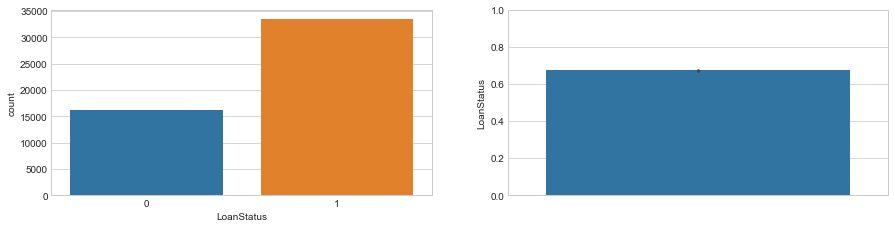

In [5]:
fig = plt.figure()

ax1 = fig.add_subplot(221)

loanStatusdf = data.select('LoanStatus', 'BorrowerState', 'ListingCategory').toPandas()

sns.countplot(loanStatusdf['LoanStatus'])

ax2 = fig.add_subplot(222)
sns.barplot(y=loanStatusdf['LoanStatus']).set_ylim([0,1])

**=> TODO: Calculate how many loans have loan status 0 (bad) vs 1 (good)

In [ ]:
#TODO: Calculate how many loans have loan status 0 (bad) vs 1 (good)

So, in the historical data as a whole, 67.43% of loans are completed. 32.57% of loans "defaulted". (During analysis, one should always bear in mind that default as we've defined it includes charge-offs, cancellations, and even any current loans with late payments. It might be more constructive to think of the loans labelled with a 0 as "bad" loans rather than outright "defaults").

Let's take a look at our new historical dataframe and then start exploring variables' relationship with default, starting with some potentially useful categorical information.

In [ ]:
loanStatusdf.describe()

### Exploring the data: categorical information <a class="anchor" id="explore1"></a>

In [ ]:
sns.barplot(x="BorrowerState", y="LoanStatus", data=loanStatusdf)

**=> TODO: Calculate Loan defualts in Alabama versus DC?

In [ ]:
# TODO: Calcualate Loan Defaults in Alabama (AL) vs DC

Let's take a look at another categorical variable: ListingCategory.


In [ ]:
sns.barplot(x="ListingCategory", y="LoanStatus", data=loanStatusdf)

**=> TODO: Calculate default rates of RV Loans ("ListingCategory" == "RV") and "Green" lonas
 

In [ ]:
# TODO Calculate defaults for LisingCategory = "RV" and ListingCategory = "GREEN"

### Exploring the data: credit scores <a class="anchor" id="explore2"></a>

**=> TODO: Use Seaborn to do bar plots for ProsperScore vs. LoanStatus**
**=> TODO: Use Seaborn to do bar plots for CreditScore vs. LoanStatus**


In [ ]:
creditscoredf = data.select('LoanStatus', 'ProsperRating (numeric)', 'ProsperScore', 'CreditScore').toPandas()


fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.barplot(x="ProsperRating (numeric)", y="LoanStatus", data=creditscoredf)

ax2 = fig.add_subplot(222)
#TODO: add seaborn barplot for ProsperScore vs LoanStatus

ax3 = fig.add_subplot(223)
#TODO: add seabornbarplot for CreditScore vs LoanStatus

Both the Prosper scores and the credit scores seem to be doing a good job of predicting default, with higher ratings defaulting less frequently. Interestingly, the loans with the highest ProsperScores (11) default more frequently than loans rated at a 9 or a 10, and there is a high degree of variance in default rate for those highly rated loans.


Let's visualize some financial variables.

### Exploring the data: financial information <a class="anchor" id="explore3"></a>

In [ ]:
fig = plt.figure()

creditscoredf = data.select('LoanStatus', 'EmploymentStatus', 'EmploymentStatusDuration', 
                                     'StatedMonthlyIncome', 'DebtToIncomeRatio', 'AvailableBankcardCredit',
                                     'BankcardUtilization', 'IsBorrowerHomeowner').toPandas()


ax1 = fig.add_subplot(221)
sns.barplot(x="EmploymentStatus", y="LoanStatus", data=creditscoredf)

ax2 = fig.add_subplot(222)
sns.boxplot(x="LoanStatus", y="EmploymentStatusDuration", data=creditscoredf).set_ylim([0,400])

There doesn't seem to be a relationship between EmploymentStatusDuration and loan default. We'll take a look at the correlation in a moment. EmploymentStatus does, however, seem to have a relationship with default. Interestingly, part-time workers defaulted less often than full-time workers. People who listed their employment status as "Other" defaulted even more often than those who weren't employed at all.

In [ ]:
x = creditscoredf["EmploymentStatusDuration"]
y = creditscoredf["LoanStatus"]

r, p = st.pearsonr(x, y)

print("The correlation between employment status duration and loan default is {}, with a p-value of {}".format(r, p))

The very weak correlation between employment status duration and loan default, as well as the lack of a statistically significant p-value, lead me to believe that we can safely drop this variable from our dataset.

Let's plot some income metrics and then some indicators of credit availability.

**=> TODO: Do a boxplot of LoanStatus vs DebtToIncomeRatio

In [ ]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.boxplot(x="LoanStatus", y="StatedMonthlyIncome", data=creditscoredf).set_ylim([0,20000])

ax2 = fig.add_subplot(222)
sns.boxplot(???).set_ylim([0,0.8]) #TODO complete LoanStatus vs DebtToIncomeRatio

Both monthly income and debt : income seem to have a relationship with default. People with higher stated incomes defaulted less often than those with lower incomes, regardless of the size of the loan. And as is intuitive, loans are more likely to default if the ratio of debt to income is higher. 

In [ ]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.boxplot(x="LoanStatus", y="AvailableBankcardCredit", data=creditscoredf).set_ylim([-1000, 50000])

ax2 = fig.add_subplot(222)
sns.boxplot(x="LoanStatus", y="BankcardUtilization", data=creditscoredf).set_ylim([0,2.5])

We find a similar picture to income, wherein the availability of bankcard credit coincides with completed loans, and the lower the proportion of bankcard utilization, the lower the likelihood of default.

In [ ]:
sns.barplot(x="IsBorrowerHomeowner", y="LoanStatus", data=creditscoredf).set_ylim([0,1])

It seems homeowners default very slightly less often than renters.

Next let's look at some credit history variables.

### Exploring the data: credit history <a class="anchor" id="explore4"></a>

**=> TODO: Do a boxplot plot in seaborn for LoanStatus vs TotalCreditLinesPast7years**
**=> TODO: Do a boxplot plot in seaborn for LoanStatus vs CurrentDelinquencies**
**=> TODO: Do a boxplot plot in seaborn for LoanStatus vs DelinquenciesLast7Years**

In [ ]:

credithistorydf = data.select('LoanStatus', 'CurrentCreditLines', 'TotalCreditLinespast7years', 
                                     'CurrentDelinquencies', 'DelinquenciesLast7Years', 'LoanOriginalAmount',
                                     'Term', 'BorrowerRate', 'CreditScore').toPandas()



fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.boxplot(x="LoanStatus", y="CurrentCreditLines", data=credithistorydf).set_ylim([0,40])

ax2 = fig.add_subplot(222)
sns.boxplot(???).set_ylim([0,100])

ax3 = fig.add_subplot(223)
sns.boxplot(???).set_ylim([0,5])

ax4 = fig.add_subplot(224)
sns.boxplot(???).set_ylim([0,20])

Number of credit lines doesn't seem to have a particularly significant relationship with default, but delinquencies do. Among loans that were completed, it is very rare for the debtor to have any current delinquencies. Likewise, a history of delinquency seems to indicate a propensity for default. Let's take a look at those correlations.

In [ ]:
delinquency = ["CurrentDelinquencies", "DelinquenciesLast7Years"]
y = credithistorydf["LoanStatus"]

for var in delinquency:
    x = credithistorydf[var]
    r, p = st.pearsonr(x, y)

    print("The correlation between {} and loan default is {}, with a p-value of {}".format(var, r, p))

Both current and historical delinquency correlate significantly (p < 0.05) with loan status. Current delinquencies in particular should be a very strong feature for us.

### Exploring the data: loan characteristics <a class="anchor" id="explore5"></a>

**=> TODO: Do a violin plot in seaborn for LoanStatus vs Term

In [ ]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.violinplot(x="LoanStatus", y="LoanOriginalAmount", data=credithistorydf).set_ylim([0,35000])

ax2 = fig.add_subplot(222)
#TODO: violin plot loan status vs term.

The distribution of the loan amount seems to be consistent between both classes. 

In [ ]:
credithistorydf["Term"].value_counts()

Prosper loans can only have a term of 12, 36, or 60 months. By far the most common is the term of 3 years. Term probably won't be of much use to us to classify our loans either then. Let's wrap up by examining interest rates.

In [ ]:
sns.distplot(credithistorydf["BorrowerRate"])

In [ ]:
credithistorydf["BorrowerRate"].describe()

The mean interest rate (without any fees) for all Prosper loans is a fairly substantial 20.35%. From my experience and a quick google, that is roughly equivalent to that of a credit card. The standard deviation is 8.25% however, meaning that the lowest 25% of borrowers are paying a much more reasonable 13.64%, but that the top 25% of borrowers are paying 27.00% and more, before fees!

**=> TODO: Do a boxplot of CreditScore vs BorrowerRate

In [ ]:
sns.boxplot(???) # TODO: Complete

Generally, loans that default have a higher interest rate than loans that are paid completely, even when controlling for credit score. 

Right, so we've had the chance to take a look at some variables and their relationship to default. It seems there are a lot of good potential features available to us, although some of them are categorical and will need some work before we can use them in all of our classifiers.